This is a separate python notebook to show the results the Extreme Case Test in which there is a larger BH in the binary system causing the smaller BH to orbit the larger one.
I will organize the test with, first:
- all the init
- all the functions
- plots from different perspectives
- Theoretical v Simulated Orbit Time
- KE, PE, and Total Energy Diagrams
- Error with Orbit Times

Initialization of the Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import scipy as sci
from scipy import integrate
from scipy.integrate import odeint
from matplotlib.patches import Ellipse
from astropy import units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import astropy.constants as const

Functions

In [5]:
# We first start with the CFL check (to see if the time steps + time used for the project don't cause instability)

def verify_CFL_condition(r1, r2, v1, v2, delta_t, G, m1, m2):
    max_speed = max(np.linalg.norm(v1), np.linalg.norm(v2))
    min_distance = np.linalg.norm(r2 - r1)
    cfl = max_speed * delta_t / min_distance
    print(f"CFL Value: {cfl}")
    return cfl <= 1

#Then we have the two body equation that we will be using:

def TwoBodyEquations(w,t,G,m1,m2):
    r1=w[:3]
    r2=w[3:6]
    v1=w[6:9]
    v2=w[9:12]
    r=np.linalg.norm(r2-r1) #Calculate magnitude or norm of vector
    dv1bydt=G*m2*(r2-r1)/r**3
    dv2bydt=G*m1*(r1-r2)/r**3
    dr1bydt=v1 #.value so odeint doesnt get messed up
    dr2bydt=v2
    r_derivs=np.concatenate((dr1bydt,dr2bydt))
    derivs=np.concatenate((r_derivs,dv1bydt,dv2bydt))
    return derivs

# We then will have all the functions needed for Kepler's Third Law
# Eccentricity
def compute_eccentricity(r_p, r_a):
    return (r_a - r_p) / (r_a + r_p)

# Semi-major axis
def compute_semi_major_axis(r_p, r_a):
    return ((r_a + r_p) / 2)

# Semi-minor axis
def compute_semi_minor_axis(a, e):
    return a * np.sqrt(1 - e**2)

# Orbital period
def compute_orbital_period(a, mu):
    return np.sqrt((4 * np.pi**2 / mu) * a**3)


Now we have the IC's

In [10]:
G = const.G.to(u.m**3 / (u.kg * u.year**2)) #change the innate time to years
#Masses
m1=1e6 * const.M_sun #mass of black hole A 
m2=1e8 * const.M_sun #mass of black hole B
# Will be adding the Standard Gravitational Parameter
mu = const.G.value * (m1.value+m2.value)
#r_i
r1=[1e14,0,0] * u.m
r2=[0,0,0] * u.m
#To arrays
r1=np.array(r1,dtype="float64")
r2=np.array(r2,dtype="float64")

#COM
r_com=(m1*r1+m2*r2)/(m1+m2)
#V_i
v1=[0,1e6, 0] *u.m/u.s
v2=[0,-1e6,0] *u.m/u.s

v1 = v1.to(u.m / u.year)
v2 = v2.to(u.m / u.year)

#To arrays
v1=np.array(v1,dtype="float64")
v2=np.array(v2,dtype="float64")
#Find velocity of COM
v_com=(m1*v1+m2*v2)/(m1+m2)

T = 10 # we can extract a from here - whole time in seconds
N = 50000
delta_t = T/ N

We can then check to make sure the T & N are in a good area to not cause mishaps within the plots

In [11]:
cfl_check = verify_CFL_condition(r1, r2, v1, v2, delta_t, G, m1, m2)
print(f"CFL  Satisfied: {cfl_check}")

CFL Value: 6.311520000000001e-05
CFL  Satisfied: True


Now the bulk of the code for the plots with 6 different perspectives

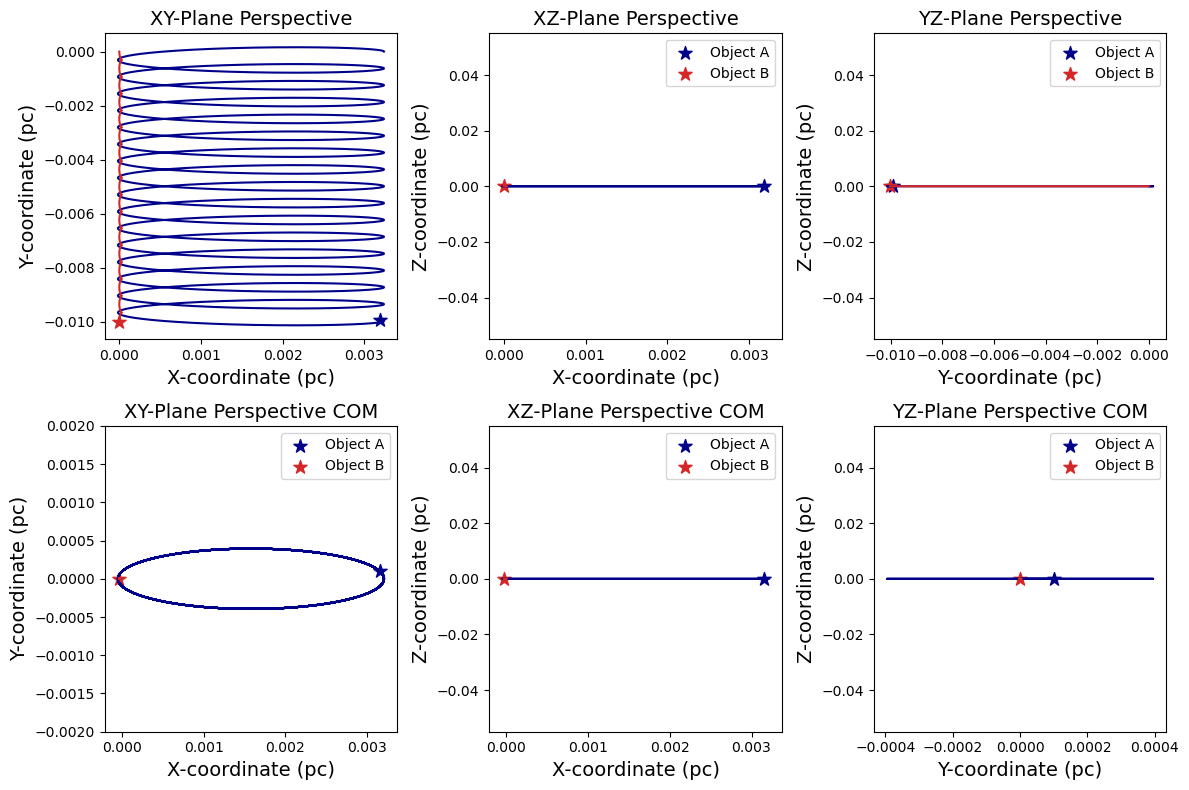

In [12]:
#Package initial parameters
init_params=np.array([r1,r2,v1,v2]) #create array of initial params
init_params=init_params.flatten() #flatten array to make it 1D
time_span=np.linspace(0, T, N) #Work on this with Kris' link



two_body_sol=sci.integrate.odeint(TwoBodyEquations,init_params,time_span,args=(G.value,m1.value,m2.value)) #make sure to understand what is within this variable

r1_sol = u.m.to(u.pc, two_body_sol[:, :3])
r2_sol = u.m.to(u.pc, two_body_sol[:, 3:6])

#Find location of COM
rcom_sol=(m1.value*r1_sol+m2.value*r2_sol)/(m1.value+m2.value)

r1com_sol=r1_sol-rcom_sol

r2com_sol=r2_sol-rcom_sol  
#Create figure
fig, axs = plt.subplots(2, 3, figsize=(12, 8)) #looked at article to see how I can line up three differnt persepctives in a row

# region Code Snippet 1: Plot the orbits for XY plane (0,1) in indices
axs[0,0].plot(r1_sol[:,0],r1_sol[:,1],color="darkblue")
axs[0,0].plot(r2_sol[:,0],r2_sol[:,1],color="tab:red")
axs[0,0].scatter(r1_sol[-1,0],r1_sol[-1,1],color="darkblue",marker="*",s=100)
axs[0,0].scatter(r2_sol[-1,0],r2_sol[-1,1],color="tab:red",marker="*",s=100)
axs[0,0].set_xlabel("X-coordinate (pc)",fontsize=14)
axs[0,0].set_ylabel("Y-coordinate (pc)",fontsize=14)
axs[0,0].set_title("XY-Plane Perspective",fontsize=14)

# # Create an inset of the zoomed-in view on the center of mass within the specific subplot
# axins = inset_axes(axs[0, 0], width="30%", height="30%", loc='upper right')  # adjust width and height as needed

# # Plot the center of mass trajectory on the inset
# axins.plot(rcom_sol[:, 0], rcom_sol[:, 1], color="tab:purple")
# axins.scatter(rcom_sol[-1, 0], rcom_sol[-1, 1], color="tab:purple", marker="o", s=100)

# # Set zoomed-in limits
# zoom_margin = 0.0001
# axins.set_xlim(rcom_sol[-1, 0] - zoom_margin, rcom_sol[-1, 0] + zoom_margin)
# axins.set_ylim(rcom_sol[-1, 1] - zoom_margin, rcom_sol[-1, 1] + zoom_margin)

# # Remove inset axis labels
# axins.set_xticklabels([])
# axins.set_yticklabels([])

# # Optionally, add a rectangle in the main plot to highlight the zoomed area
# axs[0, 0].indicate_inset_zoom(axins)

# endregion

# region Code Snippet 2: Plot the orbits for XZ plane (0,2) in indices
axs[0,1].plot(r1_sol[:,0],r1_sol[:,2],color="darkblue")
axs[0,1].plot(r2_sol[:,0],r2_sol[:,2],color="tab:red")
axs[0,1].scatter(r1_sol[-1,0],r1_sol[-1,2],color="darkblue",marker="*",s=100,label="Object A")
axs[0,1].scatter(r2_sol[-1,0],r2_sol[-1,2],color="tab:red",marker="*",s=100,label="Object B")
axs[0,1].set_xlabel("X-coordinate (pc)",fontsize=14)
axs[0,1].set_ylabel("Z-coordinate (pc)",fontsize=14)
axs[0,1].set_title("XZ-Plane Perspective",fontsize=14)
axs[0,1].legend()
# endregion

# region Code Snippet 3: Plot the orbits for YZ plane (1,2) in indices
axs[0,2].plot(r1_sol[:,1],r1_sol[:,2],color="darkblue")
axs[0,2].plot(r2_sol[:,1],r2_sol[:,2],color="tab:red")
axs[0,2].scatter(r1_sol[-1,1],r1_sol[-1,2],color="darkblue",marker="*",s=100,label="Object A")
axs[0,2].scatter(r2_sol[-1,1],r2_sol[-1,2],color="tab:red",marker="*",s=100,label="Object B")
axs[0,2].set_xlabel("Y-coordinate (pc)",fontsize=14)
axs[0,2].set_ylabel("Z-coordinate (pc)",fontsize=14)
axs[0,2].set_title("YZ-Plane Perspective",fontsize=14)
axs[0,2].legend()
# endregion

# region Code Snippet 4: Plot the orbits for XY plane (0,1) in indices but COM
axs[1,0].plot(r1com_sol[:,0],r1com_sol[:,1],color="darkblue")
axs[1,0].plot(r2com_sol[:,0],r2com_sol[:,1],color="tab:red")
axs[1,0].set_ylim([-0.002, 0.002])
# axs[1,0].scatter(rcom_sol[:, 0], rcom_sol[:, 1], color="tab:purple", marker = "*", s = 100, label="Center of Mass Trajectory")
axs[1,0].scatter(r1com_sol[-1,0],r1com_sol[-1,1],color="darkblue",marker="*",s=100,label="Object A")
axs[1,0].scatter(r2com_sol[-1,0],r2com_sol[-1,1],color="tab:red",marker="*",s=100,label="Object B")
axs[1,0].set_xlabel("X-coordinate (pc)",fontsize=14)
axs[1,0].set_ylabel("Y-coordinate (pc)",fontsize=14)
axs[1,0].set_title("XY-Plane Perspective COM",fontsize=14)
axs[1,0].legend()

# endregion

# region Code Snippet 5: Plot the orbits for XZ plane (0,2) in indices but COM
axs[1,1].plot(r1com_sol[:,0],r1com_sol[:,2],color="darkblue")
axs[1,1].plot(r2com_sol[:,0],r2com_sol[:,2],color="tab:red")
axs[1,1].scatter(r1com_sol[-1,0],r1com_sol[-1,2],color="darkblue",marker="*",s=100,label="Object A")
axs[1,1].scatter(r2com_sol[-1,0],r2com_sol[-1,2],color="tab:red",marker="*",s=100,label="Object B")
axs[1,1].set_xlabel("X-coordinate (pc)",fontsize=14)
axs[1,1].set_ylabel("Z-coordinate (pc)",fontsize=14)
axs[1,1].set_title("XZ-Plane Perspective COM",fontsize=14)
axs[1,1].legend()
# endregion

# region Code Snippet 6: Plot the orbits for YZ plane (1,2) in indices but COM
axs[1,2].plot(r1com_sol[:,1],r1com_sol[:,2],color="darkblue")
axs[1,2].plot(r2com_sol[:,1],r2com_sol[:,2],color="tab:red")
axs[1,2].scatter(r1com_sol[-1,1],r1com_sol[-1,2],color="darkblue",marker="*",s=100,label="Object A")
axs[1,2].scatter(r2com_sol[-1,1],r2com_sol[-1,2],color="tab:red",marker="*",s=100,label="Object B")
axs[1,2].set_xlabel("Y-coordinate (pc)",fontsize=14)
axs[1,2].set_ylabel("Z-coordinate (pc)",fontsize=14)
axs[1,2].set_title("YZ-Plane Perspective COM",fontsize=14)
axs[1,2].legend()
# endregion

plt.tight_layout() 
plt.show()



We can then do a plot to see how the positions of BH A moves (to make sure that we can cross-check this with the simulated orbit time)

Simulated Orbital Period: 0.622012 years


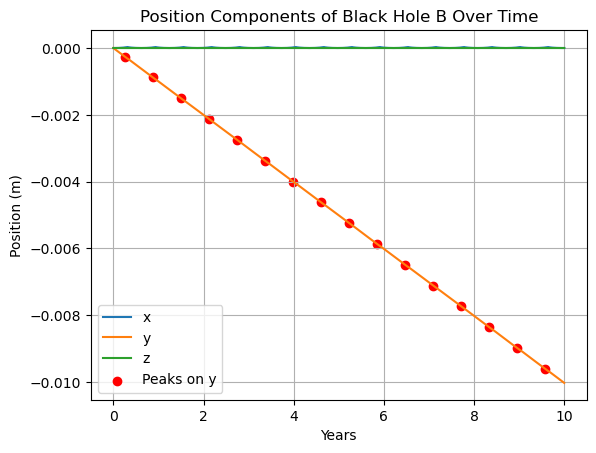

In [18]:
from scipy.signal import find_peaks


y_relative_to_center = r1com_sol[:, 1]


peaks, _ = find_peaks(y_relative_to_center)


if len(peaks) >= 2:
    first_peak_time = time_span[peaks[0]]
    second_peak_time = time_span[peaks[1]]
    orbital_period = second_peak_time - first_peak_time
    orbital_period_years = orbital_period
    print(f"Simulated Orbital Period: {orbital_period_years:.6f} years")


    plt.plot(time_span, r2_sol[:, 0], label='x')
    plt.plot(time_span, r2_sol[:, 1], label='y')
    plt.plot(time_span, r2_sol[:, 2], label='z')


    plt.scatter(time_span[peaks], r2_sol[peaks, 1], color='red', label='Peaks on y')

    plt.xlabel('Years')
    plt.ylabel('Position (m)')
    plt.title('Position Components of Black Hole B Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Could not find two peaks to determine the orbital period.")

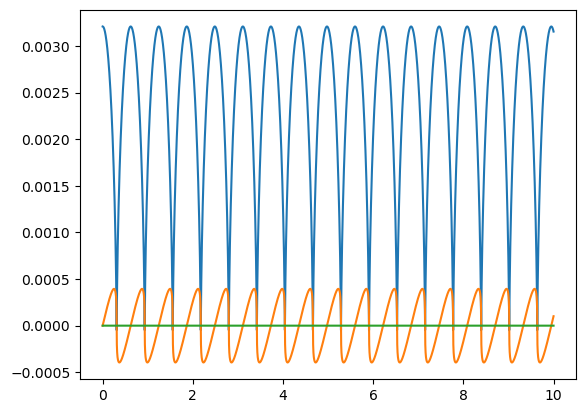

In [17]:
plt.plot(time_span, r1com_sol)

Now we can check the Theoretical Orbit Time

In [22]:
distance1 = np.linalg.norm(u.pc.to(u.m, r1_sol - r2_sol), axis= 1)

p_distance1 = np.min(distance1)
a_distance1 = np.max(distance1)

distance2 = np.linalg.norm(u.pc.to(u.m, r2com_sol), axis = 1)

p_distance2 = np.min(distance2)
a_distance2 = np.max(distance2)


# Theoretical data
# Eccentricity and Semi-Major Axis for Black Hole A
r_p1 = p_distance1
r_a1 = a_distance1
eccentricity1 = compute_eccentricity(r_p1, r_a1)
a1 = compute_semi_major_axis(r_p1, r_a1)

# Eccentricity and Semi-Major Axis for Black Hole B
r_p2 = p_distance2
r_a2 = a_distance2
eccentricity2 = compute_eccentricity(r_p2, r_a2)
a2 = compute_semi_major_axis(r_p2, r_a2)

# Semi Minor Axis for Black Hole A and B
b1 = compute_semi_minor_axis(a1, eccentricity1)
b2 = compute_semi_minor_axis(a2, eccentricity2)

# Orbital periods of the black holes
T1 = compute_orbital_period(a1, mu)
T2 = compute_orbital_period(a2, mu)


print(f"Eccentricity of the A orbit: {round(eccentricity1, 4)}") #WOOOOOOOH IT IS  0 < EPSILON < 1 !!!!
print(f"Eccentricity of the B orbit: {round(eccentricity2, 4)}") 
print(f"Semi-Major Axis of the orbit A: {round(u.m.to(u.pc,a1), 6)} pc")
print(f"Semi-Major Axis of the orbit B: {round(u.m.to(u.pc, a2), 6)} pc")
print(f"Semi-Minor Axis of the orbit A: {round(u.m.to(u.pc, b1), 6)} pc")
print(f"Semi-Minor Axis of the orbit B: {round(u.m.to(u.pc, b2), 6)} pc")
print(f"Theoretical Orbital Period of BH A: {round(u.s.to(u.year, T1), 6)} yrs")
print(f"Theoretical Orbital Period of BH B: {round(u.s.to(u.year, T2), 6)} yrs")



Eccentricity of the A orbit: 0.9702
Eccentricity of the B orbit: 0.9702
Semi-Major Axis of the orbit A: 0.001645 pc
Semi-Major Axis of the orbit B: 1.6e-05 pc
Semi-Minor Axis of the orbit A: 0.000399 pc
Semi-Minor Axis of the orbit B: 4e-06 pc
Theoretical Orbital Period of BH A: 0.621882 yrs
Theoretical Orbital Period of BH B: 0.000613 yrs


Now, we will compare with angles and positions and get the error

Simulated Orbital Period: 0.622012 years


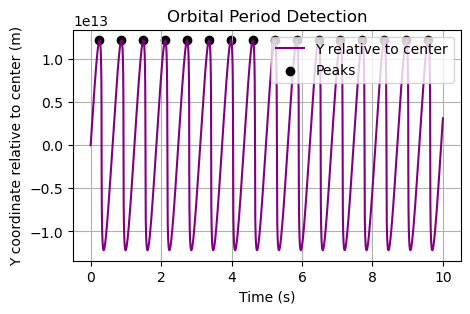

In [25]:
from scipy.signal import find_peaks
y_relative_to_center = u.pc.to(u.m, r1_sol[:, 1] - rcom_sol[:, 1])


peaks, _ = find_peaks(y_relative_to_center)

if len(peaks) >= 8:
    first_peak_time = time_span[peaks[0]]
    second_peak_time = time_span[peaks[1]]
    orbital_period = second_peak_time - first_peak_time
    orbital_period_years = orbital_period
    print(f"Simulated Orbital Period: {orbital_period_years:4f} years")


    plt.figure(figsize=(5, 3))
    plt.plot(time_span, y_relative_to_center, label='Y relative to center', color='purple')
    plt.scatter(time_span[peaks], y_relative_to_center[peaks], color='black', label='Peaks')
    plt.xlabel('Time (s)')
    plt.ylabel('Y coordinate relative to center (m)')
    plt.title('Orbital Period Detection')
    plt.grid(True)
    plt.legend(loc = "upper right")
    plt.show()
else:
    print("Could not find two peaks to determine the orbital period.")


In [26]:
#Calculations Using Positions

print(f"Theoretical Orbital Period of BH A: {round(u.s.to(u.year, T1), 6)} yrs")
print(f"Theoretical Orbital Period of BH B: {round(u.s.to(u.year, T2), 6)} yrs")
print(f"Simulated Orbital Period of BH A: {orbital_period_years} years")


percent_error = ((u.s.to(u.year, T1) - orbital_period_years) / u.s.to(u.year, T1)) * 100 * -1
print(f"Percent Error Using Positions = {round(percent_error, 4)} %")

Theoretical Orbital Period of BH A: 0.621882 yrs
Theoretical Orbital Period of BH B: 0.000613 yrs
Simulated Orbital Period of BH A: 0.622012440248805 years
Percent Error Using Positions = 0.021 %


Now angles

Simulated Orbital Period: 0.6218 years


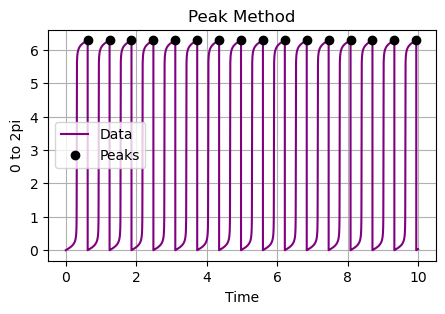

1st Peak Time: 0.62 yrs (Index: 3109)
2nd Peak Time: 1.24 yrs (Index: 6218)
Simulated Orbital Period: 0.6218 years


In [28]:
from scipy.signal import find_peaks

#COM
# r1com_x = r1_sol_pc[:, 0] - rcom_sol[:, 0]
# r1com_y = r1_sol_pc[:, 1] - rcom_sol[:, 1]
# angles = np.arctan2(r1com_y, r1com_x)

c1y = (np.max(r1_sol[:,1]) + np.min(r1_sol[:,1])) / 2
c1x = (np.max(r1_sol[:,0]) + np.min(r1_sol[:,0])) / 2
c = np.array([u.pc.to(u.m,c1x), u.pc.to(u.m, c1y), 0])


angles = np.arctan2(u.pc.to(u.m, r1_sol[:, 1]) -  u.pc.to(u.m, rcom_sol[:,1]), u.pc.to(u.m, r1_sol[:, 0]) - u.pc.to(u.m, rcom_sol[:,0]))  # arctan2 gives the angle in radians

# angles = np.arctan2(u.pc.to(u.m, r1_sol[:, 1]) -  c[1], u.pc.to(u.m, r1_sol[:, 0]) - c[0]) #apparently, using the center of the ellipses and the COM does not have affect on teh orbital period?



angles_norm = angles - angles[0]
angles_norm = np.mod(angles_norm, 2 * np.pi)


peaks, _ = find_peaks(angles_norm)


if len(peaks) >= 2:
    orbital_period = time_span[peaks[1]] - time_span[peaks[0]]
    orbital_period_years = orbital_period 
    print(f"Simulated Orbital Period: {orbital_period_years:.4f} years")
else:
    print("None")


plt.figure(figsize=(5, 3))
plt.plot(time_span, angles_norm, label='Data', color = 'purple')
plt.plot(time_span[peaks], angles_norm[peaks], 'o', color='black', label='Peaks')
plt.xlim()
plt.xlabel('Time')
plt.ylabel('0 to 2pi')
plt.title('Peak Method')
plt.grid(True)
plt.legend()
plt.show()

if len(peaks) >= 2:
    first_peak_time = time_span[peaks[0]]
    print(f"1st Peak Time: {first_peak_time:.2f} yrs (Index: {peaks[0]})")

    second_peak_time = time_span[peaks[1]]
    print(f"2nd Peak Time: {second_peak_time:.2f} yrs (Index: {peaks[1]})")

    orbital_period = second_peak_time - first_peak_time
    orbital_period_years = orbital_period 
    print(f"Simulated Orbital Period: {orbital_period_years:.4f} years")
else:
    print("None")

In [29]:
#Calculations Using Angle


print(f"Theoretical Orbital Period of BH A: {round(u.s.to(u.year, T1), 6)} yrs")
print(f"Theoretical Orbital Period of BH B: {round(u.s.to(u.year, T2), 6)} yrs")
print(f"Simulated Orbital Period of BH A: {orbital_period_years} years")

percent_error = ((u.s.to(u.year, T1) - orbital_period_years) / u.s.to(u.year, T1)) * 100 
print(f"Percent Error Using Angles = {percent_error:4f} %")

Theoretical Orbital Period of BH A: 0.621882 yrs
Theoretical Orbital Period of BH B: 0.000613 yrs
Simulated Orbital Period of BH A: 0.621812436248725 years
Percent Error Using Angles = 0.011136 %


Now we do the Energy Calculations

In [40]:
r1_sol

array([[ 3.24077929e-03,  0.00000000e+00,  0.00000000e+00],
       [ 3.24077843e-03,  2.04546488e-07,  0.00000000e+00],
       [ 3.24077586e-03,  4.09092759e-07,  0.00000000e+00],
       ...,
       [ 3.18702361e-03, -9.92372553e-03,  0.00000000e+00],
       [ 3.18659074e-03, -9.92352787e-03,  0.00000000e+00],
       [ 3.18615611e-03, -9.92333027e-03,  0.00000000e+00]])

In [56]:
r1_sol

array([[ 3.24077929e-03,  0.00000000e+00,  0.00000000e+00],
       [ 3.24077843e-03,  2.04546488e-07,  0.00000000e+00],
       [ 3.24077586e-03,  4.09092759e-07,  0.00000000e+00],
       ...,
       [ 3.18702361e-03, -9.92372553e-03,  0.00000000e+00],
       [ 3.18659074e-03, -9.92352787e-03,  0.00000000e+00],
       [ 3.18615611e-03, -9.92333027e-03,  0.00000000e+00]])

The average energy would be 3.522293889375389e+80 J
The fractional energy would be 1.5006662579253316e-16 J
Using the Fractional Energy method, we get the percent change of 1.2514647096395492e-14 %


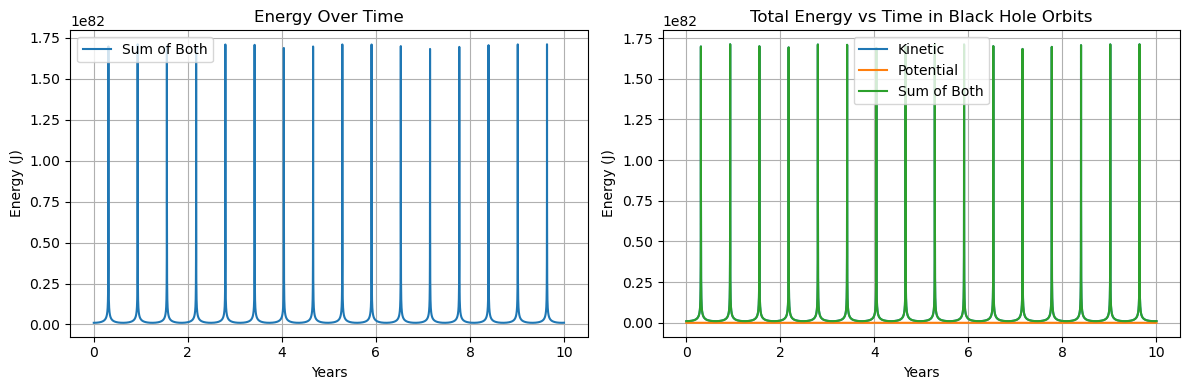

[9.95894094e+79 9.95894772e+79 9.95896806e+79 ... 1.03900105e+80
 1.03935504e+80 1.03971058e+80]


In [62]:
v1_sol = u.year.to(u.s, two_body_sol[:, 6:9])
v2_sol = u.year.to(u.s, two_body_sol[:, 9:12])

KE = (0.5 * m1.value * np.sum(v1_sol**2, axis=1)) + (0.5 * m2.value * np.sum(v2_sol**2, axis=1))
V = -const.G.value * (m1.value + m2.value) / np.linalg.norm(u.pc.to(u.m, (r1_sol - r2_sol)), axis = 1)
E = V + KE

time_span_year = time_span
avg_energy = np.mean(E)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
# region Code Snippet 6: Energy Graph Plot

axs[0].plot(time_span_year, E, label = "Sum of Both")
axs[0].set_xlabel("Years")
axs[0].set_ylabel("Energy (J)")
axs[0].set_title("Energy Over Time")
axs[0].legend()
axs[0].grid()

# endregion
# region Code Snippet 7: Energy Graph Plot

axs[1].plot(time_span_year, KE, label="Kinetic")
axs[1].plot(time_span_year, V, label = "Potential") 
axs[1].plot(time_span_year, E, label = "Sum of Both")
axs[1].set_xlabel("Years")
axs[1].set_ylabel("Energy (J)")
axs[1].set_title("Total Energy vs Time in Black Hole Orbits")
axs[1].legend()
axs[1].grid()
# endregion

#Fractional Energy work >

frac_energy = (E - avg_energy) / avg_energy
percent = frac_energy * 100

print(f"The average energy would be {round(avg_energy,6)} J")
print(f"The fractional energy would be {np.mean(frac_energy)} J")
print(f"Using the Fractional Energy method, we get the percent change of {np.mean(percent)} %")

plt.tight_layout()
plt.show()
print(KE)


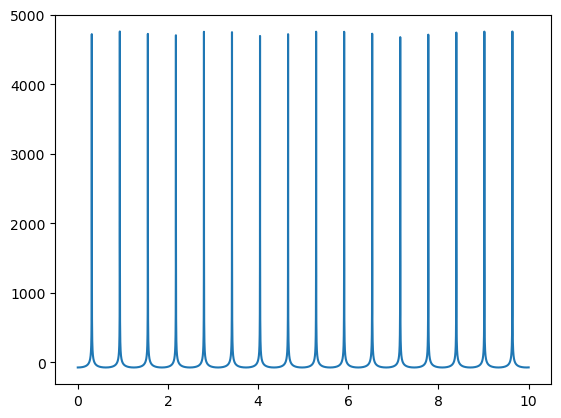

In [63]:
plt.plot(time_span_year, percent)

Might need to make corrections on the energy plot(?)